<h1 style="text-align:center;"><b>Laboratorio 4</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Ariela Mishaan (22052), Marcos Díaz (221102) </h3>

# Librerías

In [2]:
#import sys
#!{sys.executable} -m pip install --user "folium"

In [60]:
import rasterio
from datetime import date
import openeo
import os, glob
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Conexión

In [2]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


# Extracción de datos

## Coordenadas

In [3]:
#Areas de interes
lago_atitlan = {
    "west": -91.326256,
    "east": -91.07151,
    "south": 14.5948,
    "north": 14.750979
}
lago_amatitlan = {
    "west": -90.638065,
    "east": -90.512924,
    "south": 14.412347,
    "north": 14.493799
}

## Conexión

In [4]:
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## Descarga de imágenes

In [5]:
# Fechas sin nubosidad
fechas = ["2025-02-07", "2025-02-10", "2025-02-25", "2025-02-27", "2025-03-02", "2025-03-04", "2025-03-07", "2025-03-09", "2025-03-12", "2025-03-14", "2025-03-19", "2025-03-22", "2025-03-24", "2025-03-26", "2025-04-03", "2025-04-11", "2025-04-13", "2025-04-15", "2025-04-16", "2025-04-18", "2025-04-28", "2025-05-03", "2025-05-13", "2025-05-28", "2025-07-10", "2025-07-17", "2025-07-20", "2025-07-24", "2025-08-01"]

In [6]:
for fecha in fechas:
    try:
        # Lago Atitlán
        atitlan_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=lago_atitlan,
            temporal_extent=[fecha, fecha],  # o un rango más amplio
            bands=["B02","B03","B04", "B05", "B07", "B08", "B8A", "B11", "B12"]
        )

        result_graph = atitlan_cube.save_result(format="GTIFF")
        job = connection.create_job(result_graph)
        job.start_and_wait()
        job.download_results(f"imgs1/{fecha}.tiff")

        # Lago Amatitlán
        amatitlan_cube = connection.load_collection(
            "SENTINEL2_L2A",
            spatial_extent=lago_amatitlan,
            temporal_extent=[fecha, fecha],
            bands=["B02","B03","B04", "B05", "B07", "B08", "B8A", "B11", "B12"]
        )

        result_graph = amatitlan_cube.save_result(format="GTIFF")
        job = connection.create_job(result_graph)
        job.start_and_wait()
        job.download_results(f"imgs2/{fecha}.tiff")

    except Exception as e:
        print(f"No se pudo procesar la fecha {fecha}: {e}")
        continue

0:00:00 Job 'j-25081421443649e09ee4598e2c103866': send 'start'
0:00:13 Job 'j-25081421443649e09ee4598e2c103866': created (progress 0%)


KeyboardInterrupt: 

# Funciones para cálcular índices

In [6]:
def read_tif_robusto(path):
    bad_tiles = {}
    with rasterio.open(path) as src:
        count, height, width = src.count, src.height, src.width
        arr = np.full((count, height, width), np.nan, dtype=np.float32)
        nodata = src.nodata

        for bidx in range(1, count + 1):
            bad_tiles[bidx] = []
            for ji, window in src.block_windows(bidx):
                try:
                    data = src.read(bidx, window=window, masked=False)
                    r0, r1 = window.row_off, window.row_off + window.height
                    c0, c1 = window.col_off, window.col_off + window.width
                    arr[bidx - 1, r0:r1, c0:c1] = data.astype(np.float32, copy=False)
                except Exception:
                    bad_tiles[bidx].append((ji, window))  # deja NaN en ese bloque y sigue
    return arr, nodata, bad_tiles

In [7]:
MNDWI_threshold = 0.42
NDWI_threshold  = 0.4
filter_UABS     = True   
EPS = 1e-9    

In [8]:
def nd_simple(num, den):
    num = num.astype(np.float32, copy=False)
    den = den.astype(np.float32, copy=False)
    out = np.full_like(num, np.nan, dtype=np.float32)
    np.divide(num, den, out=out, where=np.abs(den) > EPS)
    return out

In [9]:
def normalize(b):
    b = b.astype(np.float32, copy=False)
    valid = b[np.isfinite(b) & (b > 0)]
    if valid.size < 10:
        return np.zeros_like(b, dtype=np.float32)
    b_min, b_max = np.percentile(valid, (2, 98))
    if (b_max - b_min) < EPS:
        return np.zeros_like(b, dtype=np.float32)
    x = (b - b_min) / (b_max - b_min)
    return np.clip(x, 0, 1).astype(np.float32)

In [10]:
def calcular_ndvi(red, nir):
    return nd_simple(nir - red, nir + red)

In [11]:
def calcular_ndwi(nir, green):
    return nd_simple(green - nir, green + nir)


In [12]:
def calcular_savi(red, nir, L=0.428):
    return (1 + L) * nd_simple(nir - red, nir + red + L)

## Cianobacteria

In [13]:
def wbi(r, g, b, nir, swir1, swir2):
    r = r.astype(np.float32); g = g.astype(np.float32); b = b.astype(np.float32)
    nir = nir.astype(np.float32); swir1 = swir1.astype(np.float32); swir2 = swir2.astype(np.float32)

    ndvi = nd_simple(nir - r, nir + r)
    mndwi = nd_simple(g - swir1, g + swir1)
    ndwi = nd_simple(g - nir, g + nir)
    ndwi_leaves = nd_simple(nir - swir1, nir + swir1)

    aweish  = b + 2.5*g - 1.5*(nir + swir1) - 0.25*swir2
    aweinsh = 4*(g - swir1) - (0.25*nir + 2.75*swir1)

    dbsi = nd_simple(swir1 - g, swir1 + g) - ndvi
    wii  = nd_simple(nir**2, r)             # puede salir NaN donde r≈0
    wri  = nd_simple(g + r, nir + swir1)
    puwi = 5.83*g - 6.57*r - 30.32*nir + 2.25

    den_uwi = np.abs(g - 1.1*r - 5.2*nir)   # puede ser 0
    uwi = nd_simple(g - 1.1*r - 5.2*nir + 0.4, den_uwi)

    usi = 0.25*nd_simple(g, r) - 0.57*nd_simple(nir, g) - 0.83*nd_simple(b, g) + 1

    ws = np.zeros_like(r, dtype=np.uint8)
    water_mask = (
        (mndwi > MNDWI_threshold) |
        (ndwi > NDWI_threshold)   |
        (aweinsh > 0.1879)        |
        (aweish  > 0.1112)        |
        (ndvi    < -0.2)          |
        (ndwi_leaves > 1)
    )
    ws[water_mask] = 1

    if filter_UABS:
        urban_mask = ((aweinsh <= -0.03) | (dbsi > 0)) & (ws == 1)
        ws[urban_mask] = 0

    return ws  # 0/1 con NaN donde las entradas tenían NaN

In [14]:
def FAI(a, b, c):
    baseline = a + (c - a) * ((783 - 665) / (865 - 665))
    return b - baseline

In [15]:
def NDCI(a, b):
    return nd_simple(b - a, b + a)

In [16]:
def CHL(ndci):
    ndci = ndci.astype(np.float32, copy=False)
    return (826.57 * ndci**3 - 176.43 * ndci**2 + 19 * ndci + 4.071).astype(np.float32)

## Otras

In [61]:
def _is_valid_img(arr):
    if arr is None:
        return False
    a = np.asarray(arr)
    if a.ndim < 2:  
        return False
    return np.isfinite(a).any()

def plot_index_grid(df, col="CHL", dates=None, ncols=6, cmap="viridis", title=None, savepath=None):
    if dates is not None:
        df_use = df.loc[dates]
    else:
        df_use = df

    valid_rows = []
    for idx, arr in df_use[col].items():
        if _is_valid_img(arr):
            valid_rows.append((idx, np.asarray(arr)))

    if not valid_rows:
        print(f"No hay imágenes válidas en la columna '{col}'.")
        return

    all_vals = np.concatenate([r[1].ravel() for r in valid_rows])
    all_vals = all_vals[np.isfinite(all_vals)]
    if all_vals.size == 0:
        print(f"No hay valores finitos en la columna '{col}'.")
        return
    vmin = np.percentile(all_vals, 5)
    vmax = np.percentile(all_vals, 95)
    if vmin == vmax:  # respaldo por si todo es constante
        vmin = np.nanmin(all_vals)
        vmax = np.nanmax(all_vals)

    # 3) Armar grilla compacta
    n = len(valid_rows)
    ncols = max(1, int(ncols))
    nrows = ceil(n / ncols)

    # tamaño compacto: cada celda ~ (2.4 x 2.4) pulgadas
    fig_w = 2.4 * ncols
    fig_h = 2.6 * nrows  # un poco más para títulos
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)
    ax_list = axes.ravel()

    for ax in ax_list[n:]:
        ax.axis("off")

    for ax, (idx, arr) in zip(ax_list, valid_rows):
        img = np.asarray(arr, dtype=float)
        img = np.ma.masked_invalid(img)  # oculta NaN/inf
        im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        # título corto con la fecha
        try:
            label = pd.to_datetime(idx).strftime("%Y-%m-%d")
        except Exception:
            label = str(idx)
        ax.set_title(label, fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])

    # 4) Barra de color compartida + título general
    cbar = fig.colorbar(im, ax=ax_list[:n], fraction=0.025, pad=0.03)
    cbar.set_label(col, fontsize=9)

    if title is None:
        title = f"Serie temporal de {col} (solo imágenes válidas)"
    fig.suptitle(title, fontsize=12, y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()

In [57]:
def _first_tif(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.tif"))) + \
            sorted(glob.glob(os.path.join(folder, "*.tiff")))
    return files[0] if files else None

def _find_rgb_indices(src):
    """
    Devuelve índices (r,g,b) 0-based dentro de src.read() si es posible.
    Si no hay descriptions utilizables, asume orden [blue, green, red, ...] -> (2,1,0).
    """
    desc = src.descriptions
    if desc and any(desc):
        # normaliza descripciones (e.g., 'B02', 'B03', 'B04' o nombres largos que contienen B02, etc.)
        labels = [d or "" for d in desc]
        def find_contains(tag):
            for i, t in enumerate(labels):
                if tag in t:
                    return i
            return None
        b_idx = find_contains("B02")  # blue
        g_idx = find_contains("B03")  # green
        r_idx = find_contains("B04")  # red
        if None not in (r_idx, g_idx, b_idx):
            return (r_idx, g_idx, b_idx)
    # fallback a tu orden conocido [blue, green, red, ...]
    return (2, 1, 0)

def _percentile_stretch(band, pmin=2, pmax=98):
    vmin, vmax = np.nanpercentile(band, [pmin, pmax])
    if vmax <= vmin:
        vmax = np.nanmax(band); vmin = np.nanmin(band)
    band = np.clip((band - vmin) / (vmax - vmin + 1e-12), 0, 1)
    return band

def show_first_truecolor(folders, ncols=3, title="True Color (primera imagen por carpeta)"):
    folders = list(folders)
    valid = []
    for f in folders:
        p = _first_tif(f)
        if p:
            valid.append((f, p))
        else:
            print(f"[WARN] No encontré .tif/.tiff en: {f}")

    if not valid:
        print("No hay archivos para mostrar.")
        return

    n = len(valid)
    ncols = max(1, ncols)
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for ax in axes.ravel()[n:]:
        ax.axis("off")

    for ax, (folder, path) in zip(axes.ravel(), valid):
        with rasterio.open(path) as src:
            nodata = src.nodata
            r_idx, g_idx, b_idx = _find_rgb_indices(src)  # 0-based
            # lee solo las 3 bandas que necesitamos (1-based para rasterio.read)
            R = src.read(r_idx+1).astype(float)
            G = src.read(g_idx+1).astype(float)
            B = src.read(b_idx+1).astype(float)

        # enmascara NoData a NaN
        if nodata is not None:
            R[R == nodata] = np.nan
            G[G == nodata] = np.nan
            B[B == nodata] = np.nan

        # stretch por banda
        Rn = _percentile_stretch(R)
        Gn = _percentile_stretch(G)
        Bn = _percentile_stretch(B)

        # arma RGB (H,W,3)
        RGB = np.dstack([Rn, Gn, Bn])
        # si hay NaN, ponlos a 0 (negro) para no “quemar” con fondo blanco
        RGB = np.nan_to_num(RGB, nan=0.0, posinf=1.0, neginf=0.0)

        ax.imshow(RGB)
        ax.set_title(f"{os.path.basename(folder)}\n{os.path.basename(path)}", fontsize=9)
        ax.set_xticks([]); ax.set_yticks([])

    fig.suptitle(title, fontsize=12, y=0.98)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()


# Preparación de datos

## Visualización de un ejemplo

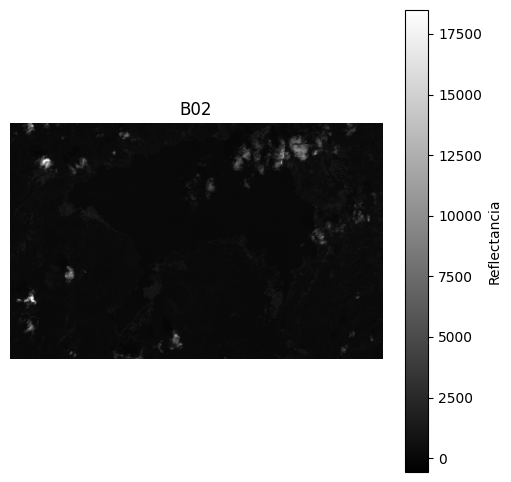

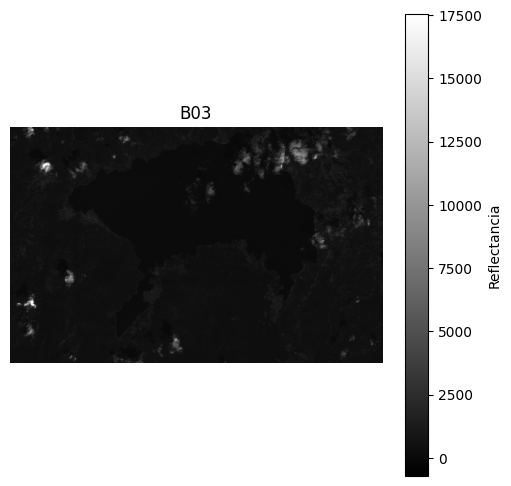

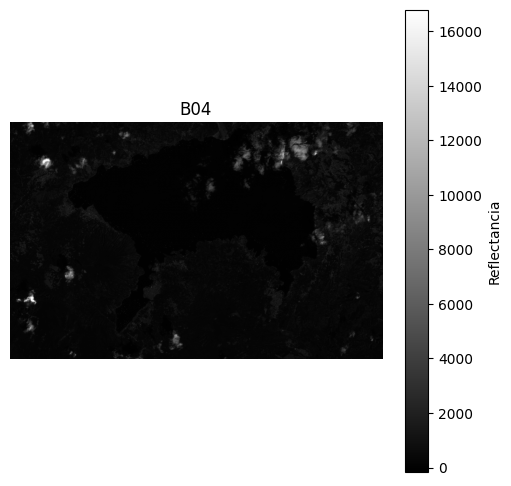

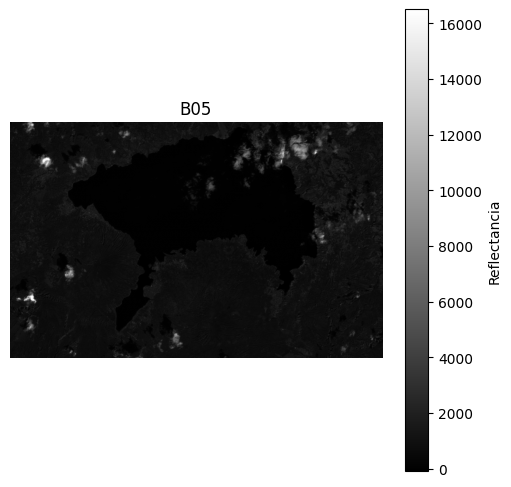

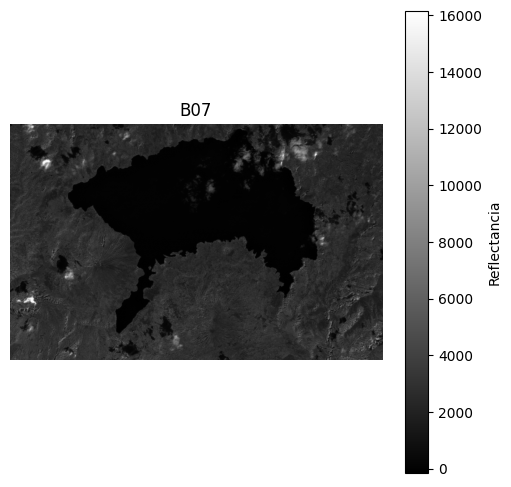

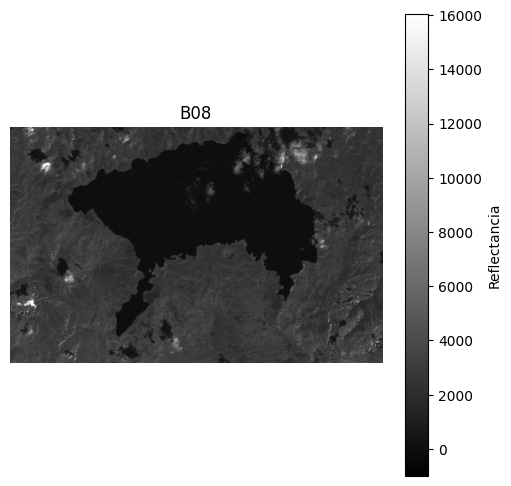

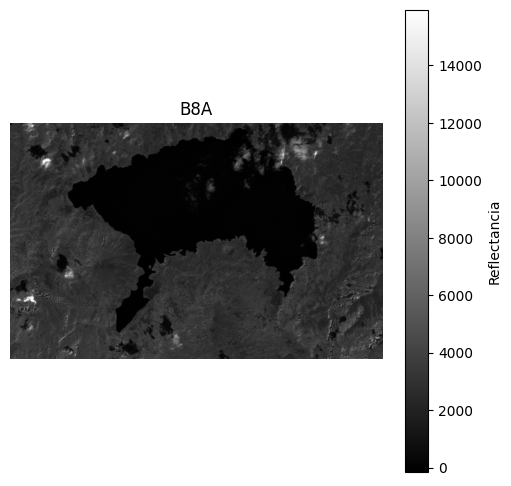

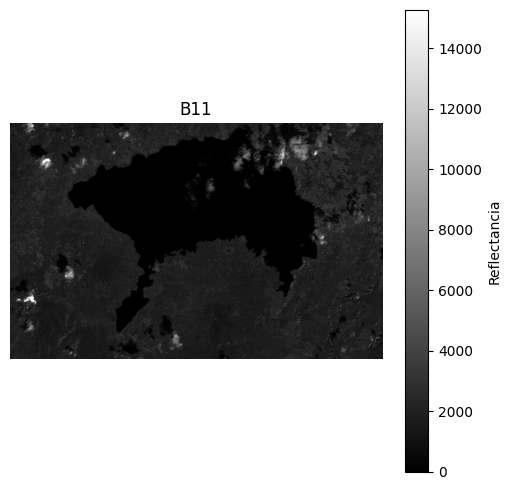

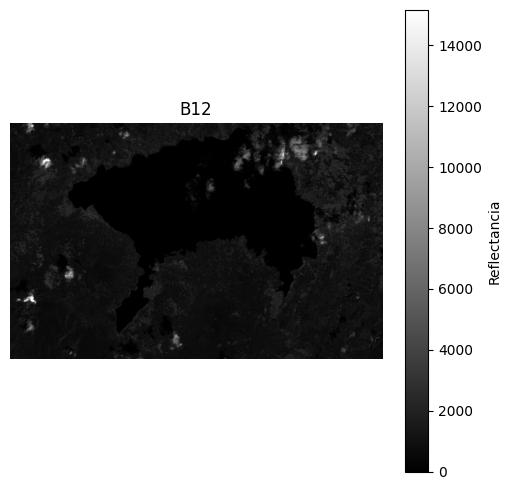

In [17]:
ruta_tif = "imgs1/2025-02-07.tiff"

with rasterio.open(ruta_tif) as src:
    bandas = src.read()  # Lee todas las bandas
    nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
    nodata = src.nodata

# Visualizar bandas individuales
for i in range(bandas.shape[0]):
    plt.figure(figsize=(6, 6))
    img = bandas[i]
    img = np.ma.masked_where(img == nodata, img)
    plt.imshow(img, cmap='gray')
    plt.title(f"{nombres[i]}")
    plt.axis('off')
    plt.colorbar(label="Reflectancia")
    plt.show()

## Unir los datos en un DF

In [18]:
start_date = fechas[0]
end_date = fechas[-1]

dates = pd.date_range(start=start_date, end=end_date, freq="D")
df_atitlan = pd.DataFrame({"Fecha": dates})
df_amatitlan = pd.DataFrame({"Fecha": dates})

print(df_atitlan)

# You can add other columns as needed
#df["Valor"] = range(len(dates))  # Example: add a 'Value' column

# Print the DataFrame to verify
#print(df)

         Fecha
0   2025-02-07
1   2025-02-08
2   2025-02-09
3   2025-02-10
4   2025-02-11
..         ...
171 2025-07-28
172 2025-07-29
173 2025-07-30
174 2025-07-31
175 2025-08-01

[176 rows x 1 columns]


# Cálculo de índices y almacenamiento en DF

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/cyanobacteria_chla_ndci_l1c/ 

## Cálculo y almacenamiento de índices

### Atitlán

In [19]:
# Fechas para nuestro dataframe
start_date = pd.to_datetime(min(fechas))
end_date   = pd.to_datetime(max(fechas))
fechas_idx = pd.date_range(start=start_date, end=end_date, freq="D")  # TODAS las fechas

# generar índices del dataframe
atitlan_mats = pd.DataFrame(index=fechas_idx)

# columnas del dataframe
for col in ["RGB","NDVI","NDWI","SAVI","WBI","FAI","NDCI","CHL"]:
        atitlan_mats[col] = pd.Series([None]*len(atitlan_mats), index=atitlan_mats.index, dtype="object")

atitlan_mats["NoData"] = np.nan

# dataframe para las estadísticas (solo las medias)
atitlan_stats = pd.DataFrame(
        index=fechas_idx,
        columns=["NDVI_mean","NDWI_mean","SAVI_mean","WBI_frac","FAI_mean","NDCI_mean","CHL_mean"],
        dtype=np.float32
    )

# leer las imágenes
for fecha in fechas:
        ruta_tif = f"imgs1/{fecha}.tiff"
        try:
                bandas, nodata, tiles_malos = read_tif_robusto(ruta_tif)
                total_malos = sum(len(v) for v in tiles_malos.values())
                if total_malos:
                        print(f"{fecha}: {total_malos} tiles dañados -> NaN")
        except Exception as e:
                print(f"[ERROR] {fecha.date()} al leer {ruta_tif}: {e}")
                atitlan_mats.at[fecha, "NoData"] = np.nan
                continue
        
        # normalizar bandas
        blue = normalize(bandas[0])
        green = normalize(bandas[1])
        red = normalize(bandas[2])
        vnir_b05 = normalize(bandas[3])
        vnir_b07 = normalize(bandas[4])
        nir = normalize(bandas[5])
        vnir_b8a = normalize(bandas[6])
        swir_b11 = normalize(bandas[7])
        swir_b12 = normalize(bandas[8])

        # calcular índices
        rgb   = np.dstack([red, green, blue]).astype(np.float32)
        ndvi  = calcular_ndvi(red, nir)
        ndwi  = calcular_ndwi(nir, green)
        savi  = calcular_savi(red, nir)
        wbi_m = wbi(red, green, blue, nir, swir_b11, swir_b12)
        fai   = FAI(red, vnir_b07, vnir_b8a)
        ndci  = NDCI(red, vnir_b05)
        chl   = CHL(ndci)

        # guardar matrices
        atitlan_mats.at[fecha, "NoData"] = nodata
        atitlan_mats.at[fecha, "RGB"]  = rgb
        atitlan_mats.at[fecha, "NDVI"] = ndvi
        atitlan_mats.at[fecha, "NDWI"] = ndwi
        atitlan_mats.at[fecha, "SAVI"] = savi
        atitlan_mats.at[fecha, "WBI"]  = wbi_m
        atitlan_mats.at[fecha, "FAI"]  = fai
        atitlan_mats.at[fecha, "NDCI"] = ndci
        atitlan_mats.at[fecha, "CHL"]  = chl

        # guardar promedio de estadísticas para el modelo
        atitlan_stats.at[fecha, "NDVI_mean"] = np.nanmean(ndvi)
        atitlan_stats.at[fecha, "NDWI_mean"] = np.nanmean(ndwi)
        atitlan_stats.at[fecha, "SAVI_mean"] = np.nanmean(savi)
        valid_wbi = wbi_m[np.isfinite(wbi_m)]
        atitlan_stats.at[fecha, "WBI_frac"]  = np.mean(valid_wbi == 1) if valid_wbi.size else np.nan
        atitlan_stats.at[fecha, "FAI_mean"]  = np.nanmean(fai)
        atitlan_stats.at[fecha, "NDCI_mean"] = np.nanmean(ndci)
        atitlan_stats.at[fecha, "CHL_mean"]  = np.nanmean(chl)

C:\Users\Alina Tatjana\AppData\Local\Temp\ipykernel_32652\3832154798.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15215517089701136' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  atitlan_stats.at[fecha, "WBI_frac"]  = np.mean(valid_wbi == 1) if valid_wbi.size else np.nan


2025-04-18: 1794 tiles dañados -> NaN
2025-04-28: 1836 tiles dañados -> NaN


### Amatitlán

In [23]:
import os

# --- Generar índices del dataframe ---
amatitlan_mats = pd.DataFrame(index=fechas_idx)

# Columnas del dataframe
for col in ["RGB","NDVI","NDWI","SAVI","WBI","FAI","NDCI","CHL"]:
    amatitlan_mats[col] = pd.Series([None]*len(amatitlan_mats),
                                    index=amatitlan_mats.index,
                                    dtype="object")

amatitlan_mats["NoData"] = np.nan

# DataFrame para las estadísticas (solo las medias)
amatitlan_stats = pd.DataFrame(
    index=fechas_idx,
    columns=["NDVI_mean","NDWI_mean","SAVI_mean","WBI_frac","FAI_mean","NDCI_mean","CHL_mean"],
    dtype=np.float32
)

# --- Leer las imágenes ---
for fecha in fechas:
    # Normaliza la fecha para indexar/imprimir
    fecha_ts = pd.to_datetime(fecha)

    # Intenta armar rutas válidas (YYYY-MM-DD y texto crudo) y extensiones .tiff/.tif
    fname_fmt = fecha_ts.strftime("%Y-%m-%d")
    candidatos = [
        os.path.join("imgs2", f"{fname_fmt}.tiff"),
        os.path.join("imgs2", f"{fname_fmt}.tif"),
        os.path.join("imgs2", f"{fecha}.tiff"),
        os.path.join("imgs2", f"{fecha}.tif"),
    ]
    ruta_tif = next((p for p in candidatos if os.path.exists(p)), None)

    if ruta_tif is None:
        print(f"[WARN] No se encontró archivo para {fecha_ts.date()} en imgs2. Probé: {', '.join(candidatos)}")
        amatitlan_mats.at[fecha_ts, "NoData"] = np.nan
        continue

    try:
        bandas, nodata, tiles_malos = read_tif_robusto(ruta_tif)
        total_malos = sum(len(v) for v in tiles_malos.values())
        if total_malos:
            print(f"{fecha_ts.date()}: {total_malos} tiles dañados -> NaN")
    except Exception as e:
        print(f"[ERROR] {fecha_ts.date()} al leer {ruta_tif}: {e}")
        amatitlan_mats.at[fecha_ts, "NoData"] = np.nan
        continue

    # Normalizar bandas
    blue      = normalize(bandas[0])
    green     = normalize(bandas[1])
    red       = normalize(bandas[2])
    vnir_b05  = normalize(bandas[3])
    vnir_b07  = normalize(bandas[4])
    nir       = normalize(bandas[5])
    vnir_b8a  = normalize(bandas[6])
    swir_b11  = normalize(bandas[7])
    swir_b12  = normalize(bandas[8])

    # Calcular índices
    rgb   = np.dstack([red, green, blue]).astype(np.float32)
    ndvi  = calcular_ndvi(red, nir)
    ndwi  = calcular_ndwi(nir, green)
    savi  = calcular_savi(red, nir)
    wbi_m = wbi(red, green, blue, nir, swir_b11, swir_b12)
    fai   = FAI(red, vnir_b07, vnir_b8a)
    ndci  = NDCI(red, vnir_b05)
    chl   = CHL(ndci)

    # Guardar matrices
    amatitlan_mats.at[fecha_ts, "NoData"] = nodata
    amatitlan_mats.at[fecha_ts, "RGB"]  = rgb
    amatitlan_mats.at[fecha_ts, "NDVI"] = ndvi
    amatitlan_mats.at[fecha_ts, "NDWI"] = ndwi
    amatitlan_mats.at[fecha_ts, "SAVI"] = savi
    amatitlan_mats.at[fecha_ts, "WBI"]  = wbi_m
    amatitlan_mats.at[fecha_ts, "FAI"]  = fai
    amatitlan_mats.at[fecha_ts, "NDCI"] = ndci
    amatitlan_mats.at[fecha_ts, "CHL"]  = chl

    # Guardar promedios
    amatitlan_stats.at[fecha_ts, "NDVI_mean"] = np.nanmean(ndvi)
    amatitlan_stats.at[fecha_ts, "NDWI_mean"] = np.nanmean(ndwi)
    amatitlan_stats.at[fecha_ts, "SAVI_mean"] = np.nanmean(savi)
    valid_wbi = wbi_m[np.isfinite(wbi_m)]
    amatitlan_stats.at[fecha_ts, "WBI_frac"]  = np.mean(valid_wbi == 1) if valid_wbi.size else np.nan
    amatitlan_stats.at[fecha_ts, "FAI_mean"]  = np.nanmean(fai)
    amatitlan_stats.at[fecha_ts, "NDCI_mean"] = np.nanmean(ndci)
    amatitlan_stats.at[fecha_ts, "CHL_mean"]  = np.nanmean(chl)


C:\Users\Alina Tatjana\AppData\Local\Temp\ipykernel_32652\1523608660.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.07713371608185259' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  amatitlan_stats.at[fecha_ts, "WBI_frac"]  = np.mean(valid_wbi == 1) if valid_wbi.size else np.nan


[WARN] No se encontró archivo para 2025-02-10 en imgs2. Probé: imgs2\2025-02-10.tiff, imgs2\2025-02-10.tif, imgs2\2025-02-10.tiff, imgs2\2025-02-10.tif
[WARN] No se encontró archivo para 2025-02-25 en imgs2. Probé: imgs2\2025-02-25.tiff, imgs2\2025-02-25.tif, imgs2\2025-02-25.tiff, imgs2\2025-02-25.tif
[WARN] No se encontró archivo para 2025-03-02 en imgs2. Probé: imgs2\2025-03-02.tiff, imgs2\2025-03-02.tif, imgs2\2025-03-02.tiff, imgs2\2025-03-02.tif
[WARN] No se encontró archivo para 2025-03-07 en imgs2. Probé: imgs2\2025-03-07.tiff, imgs2\2025-03-07.tif, imgs2\2025-03-07.tiff, imgs2\2025-03-07.tif
[WARN] No se encontró archivo para 2025-03-12 en imgs2. Probé: imgs2\2025-03-12.tiff, imgs2\2025-03-12.tif, imgs2\2025-03-12.tiff, imgs2\2025-03-12.tif
[WARN] No se encontró archivo para 2025-03-22 en imgs2. Probé: imgs2\2025-03-22.tiff, imgs2\2025-03-22.tif, imgs2\2025-03-22.tiff, imgs2\2025-03-22.tif
[ERROR] 2025-04-03 al leer imgs2\2025-04-03.tiff: 'imgs2\2025-04-03.tiff' not recognized

## Intrapolación de los datos faltantes

### Atitlán

In [24]:
# Interpolar estadísticas
atitlan_stats_interp = atitlan_stats.copy()
atitlan_stats_interp = atitlan_stats_interp.sort_index()
num_cols = atitlan_stats_interp.select_dtypes(include=[np.number]).columns
atitlan_stats_interp[num_cols] = (
    atitlan_stats_interp[num_cols]
    .interpolate(method='time', limit_direction='both')
)

### Amatitlán

In [37]:
# Interpolar estadísticas
amatitlan_stats_interp = amatitlan_stats.copy()
amatitlan_stats_interp = amatitlan_stats_interp.sort_index()
num_cols = amatitlan_stats_interp.select_dtypes(include=[np.number]).columns
amatitlan_stats_interp[num_cols] = (
    amatitlan_stats_interp[num_cols]
    .interpolate(method='time', limit_direction='both')
)

# Análisis espacial y temporal

## Análisis temporal 

### Atitlán

#### Evolución temporal de cianobacteria - gráfico de línea

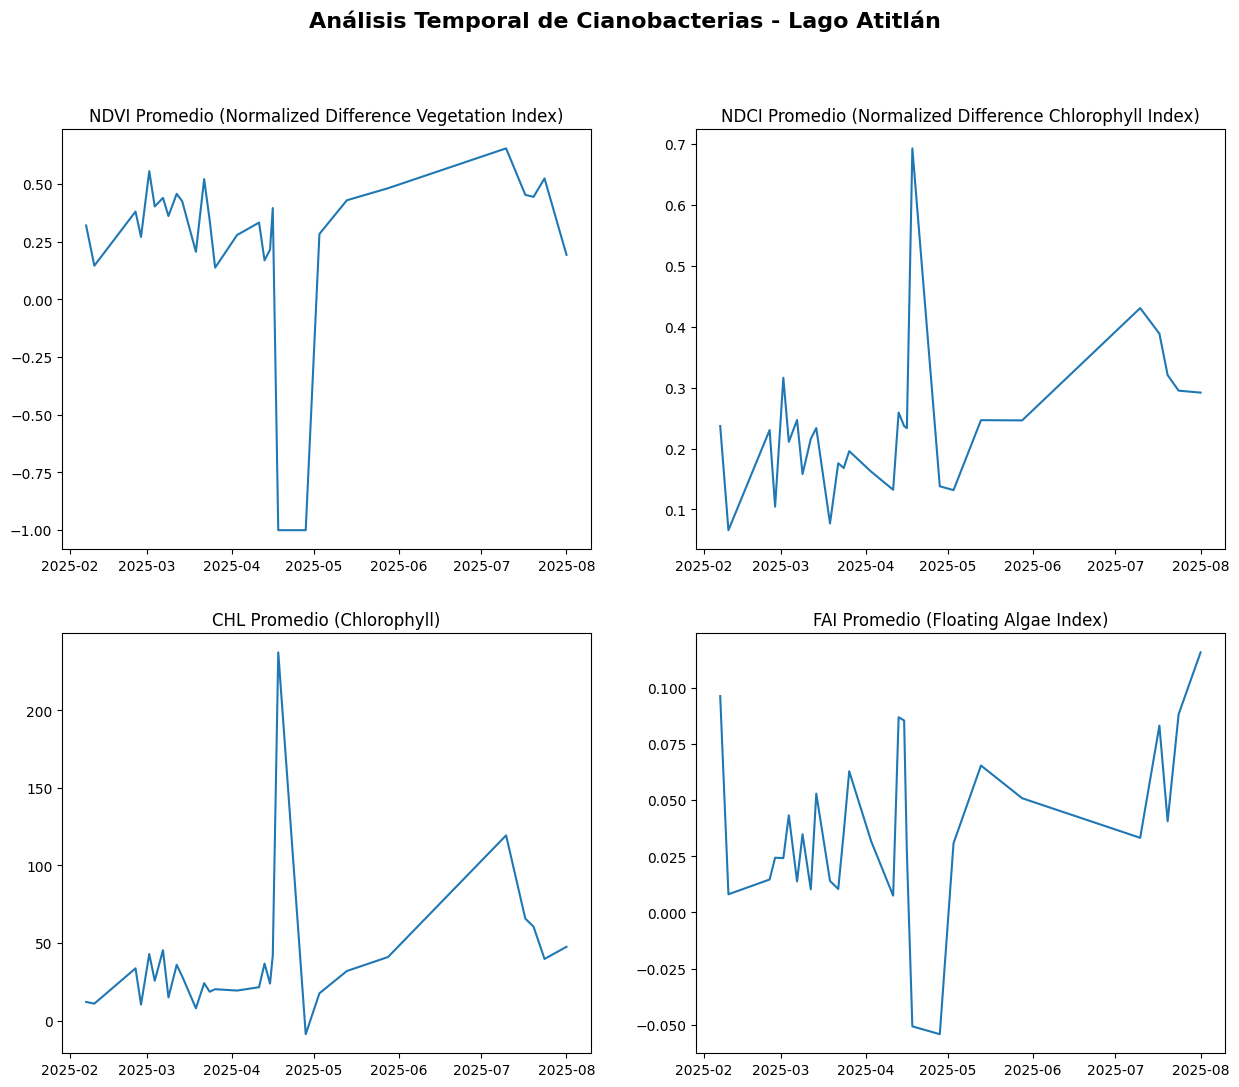

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Temporal de Cianobacterias - Lago Atitlán', fontsize=16, fontweight='bold')

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.set_title('NDVI Promedio (Normalized Difference Vegetation Index)')
ax1.plot(atitlan_stats_interp.index, atitlan_stats_interp['NDVI_mean'])

ax2.set_title('NDCI Promedio (Normalized Difference Chlorophyll Index)')
ax2.plot(atitlan_stats_interp.index, atitlan_stats_interp['NDCI_mean'])

ax3.set_title('CHL Promedio (Chlorophyll)')
ax3.plot(atitlan_stats_interp.index, atitlan_stats_interp['CHL_mean'])

ax4.set_title('FAI Promedio (Floating Algae Index)')
ax4.plot(atitlan_stats_interp.index, atitlan_stats_interp['FAI_mean'])

#### Picos de floración y fechas críticas

In [34]:
from scipy.signal import find_peaks
chl_series = atitlan_stats_interp["CHL_mean"]
peaks, _ = find_peaks(chl_series, height=0.3, distance=3)  
fechas_picos = chl_series.index[peaks]
valores_picos = chl_series.iloc[peaks]
print("Fechas con mayores floraciones:")
for fecha, valor in zip(fechas_picos, valores_picos):
    print(f"- {fecha.date()} | CHL: {valor:.3f}")

Fechas con mayores floraciones:
- 2025-02-25 | CHL: 33.659
- 2025-03-02 | CHL: 42.896
- 2025-03-07 | CHL: 45.353
- 2025-03-12 | CHL: 35.935
- 2025-03-22 | CHL: 24.086
- 2025-03-26 | CHL: 20.193
- 2025-04-13 | CHL: 36.705
- 2025-04-18 | CHL: 237.337
- 2025-07-10 | CHL: 119.373


La mayor parte del periodo, los valores de CHL se mantienen entre 0 y ~50, con fluctuaciones moderadas. Se observan aumentos puntutales de magnitud variable, algunos de los cuales destacan claramente como posibles eventos de floración. 
Las fechas con mayores floraciones son 18 de abril y el 10 de julio, ya que tienen un valor mayor de 100. La floración en julio es mdoerada, posiblemente relacionado con condiciones ambientales favorables (temperatura). En abril el pico puede deberse a un probable aumento de condiciones favorables para las plantas o una floración de alimento para ellas. 

### Amatitlán

#### Evolución temporal de cianobacteria - gráfico de línea

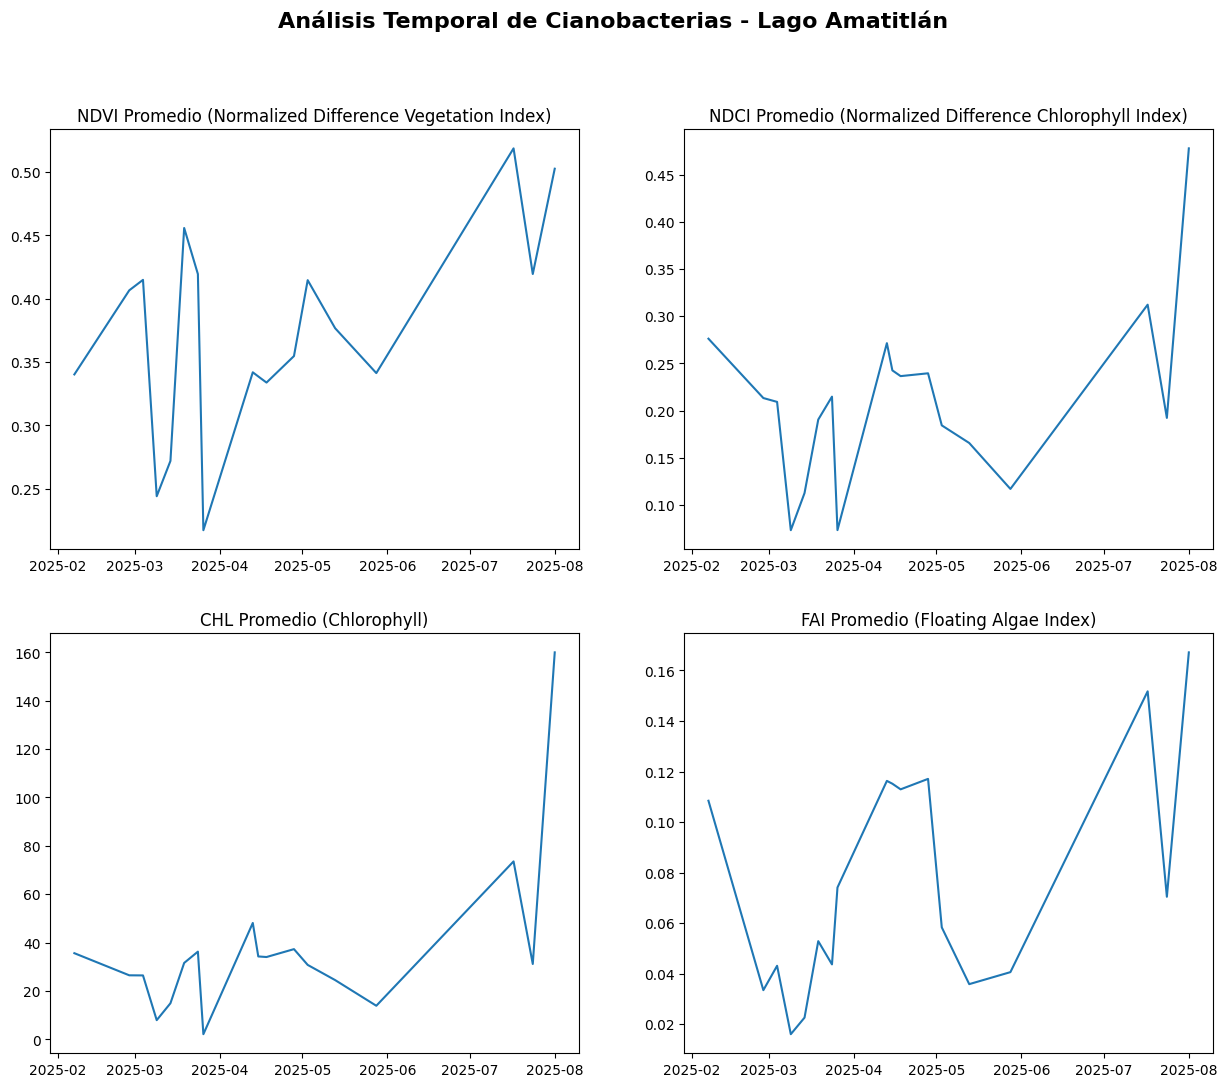

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Análisis Temporal de Cianobacterias - Lago Amatitlán', fontsize=16, fontweight='bold')

ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]

ax1.set_title('NDVI Promedio (Normalized Difference Vegetation Index)')
ax1.plot(amatitlan_stats_interp.index, amatitlan_stats_interp['NDVI_mean'])

ax2.set_title('NDCI Promedio (Normalized Difference Chlorophyll Index)')
ax2.plot(amatitlan_stats_interp.index, amatitlan_stats_interp['NDCI_mean'])

ax3.set_title('CHL Promedio (Chlorophyll)')
ax3.plot(amatitlan_stats_interp.index, amatitlan_stats_interp['CHL_mean'])
ax4.set_title('FAI Promedio (Floating Algae Index)')
ax4.plot(amatitlan_stats_interp.index, amatitlan_stats_interp['FAI_mean'])

#### Picos de floración y fechas criticas

In [40]:
chl_series = amatitlan_stats_interp["CHL_mean"]
peaks, _ = find_peaks(chl_series, height=0.3, distance=3)  
fechas_picos = chl_series.index[peaks]
valores_picos = chl_series.iloc[peaks]
print("Fechas con mayores floraciones:")
for fecha, valor in zip(fechas_picos, valores_picos):
    print(f"- {fecha.date()} | CHL: {valor:.3f}")

Fechas con mayores floraciones:
- 2025-03-24 | CHL: 36.251
- 2025-04-13 | CHL: 48.107
- 2025-04-28 | CHL: 37.285
- 2025-07-17 | CHL: 73.567


En el Lago Amatitlán se identificaron cuatro fechas críticas de posible floración de cianobacterias según el CHL promedio: el 24 de marzo de 2025 (36.251), 13 de abril de 2025 (48.107), 28 de abril de 2025 (37.285) y 17 de julio de 2025 (73.567). Los eventos de marzo y abril muestran un primer ciclo de proliferación moderada, posiblemente favorecido por el aumento de temperatura y disponibilidad de nutrientes, mientras que el pico de julio representa la floración más intensa del periodo, con condiciones ambientales propicias para un rápido crecimiento algal y potencial riesgo para la calidad del agua.

## Análisis espacial

### Atitlán

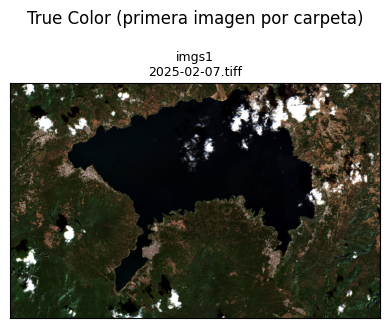

In [54]:
show_first_truecolor(["imgs1"], ncols=1)

C:\Users\Alina Tatjana\AppData\Local\Temp\ipykernel_32652\2029948993.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


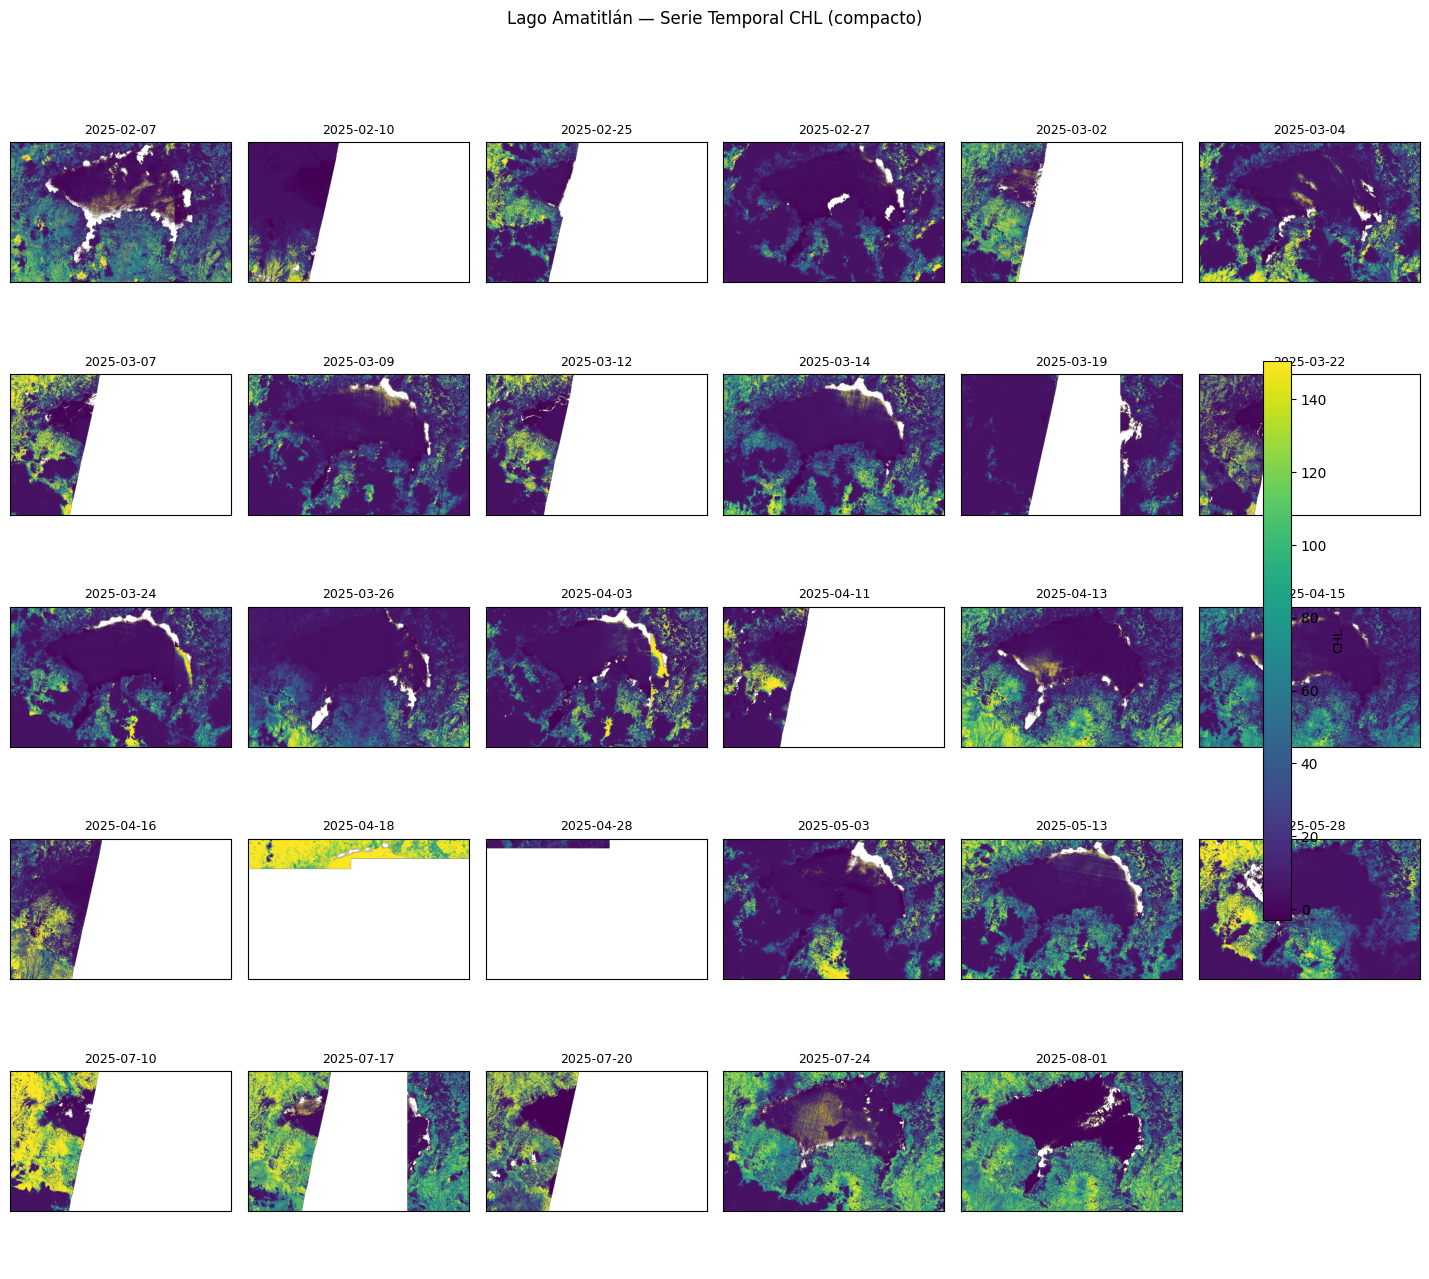

In [ ]:
plot_index_grid(atitlan_mats, col="CHL", ncols=6, cmap="viridis",
                title="Lago Amatitlán — Serie Temporal CHL (compacto)")


### Amatitlán

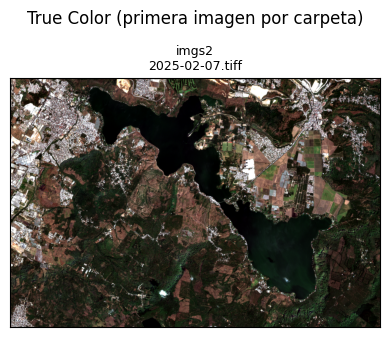

In [56]:
show_first_truecolor(["imgs2"], ncols=1)

C:\Users\Alina Tatjana\AppData\Local\Temp\ipykernel_32652\2029948993.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


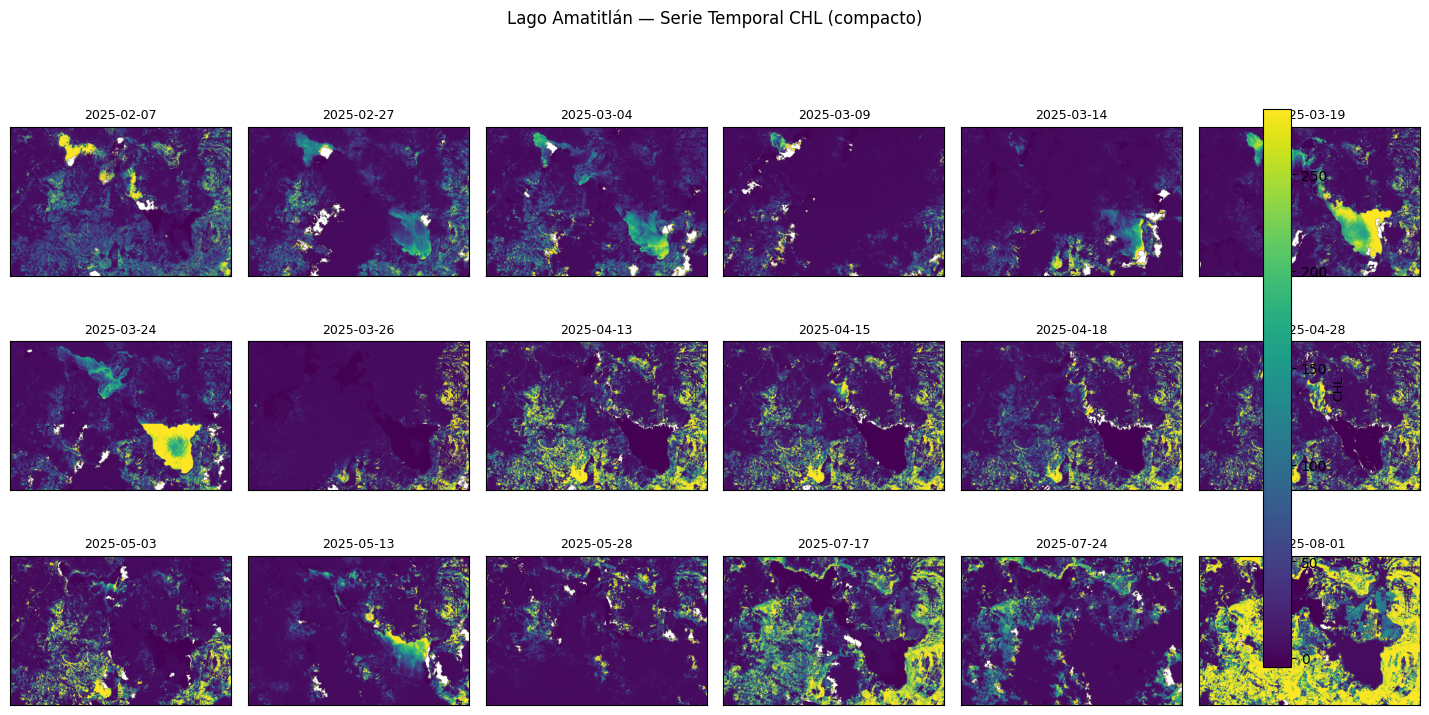

In [49]:
plot_index_grid(amatitlan_mats, col="CHL", ncols=6, cmap="viridis",
                title="Lago Amatitlán — Serie Temporal CHL (compacto)")

# Correlación de índices 
Correlación de NDVI, NDWI con presencia de cianobacteria

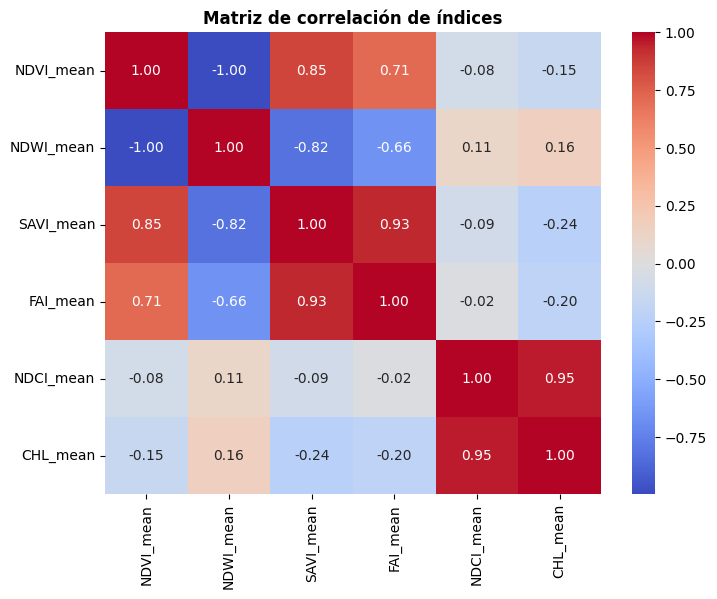

In [62]:
import seaborn as sns

# Seleccionar variables numéricas para correlación
corr_vars = atitlan_stats_interp[['NDVI_mean','NDWI_mean','SAVI_mean','FAI_mean','NDCI_mean','CHL_mean']].dropna()

# Calcular matriz de correlación
corr_matrix = corr_vars.corr()

# Plot estilo corrplot
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Matriz de correlación de índices", fontweight='bold')
plt.show()

La matriz de correlación muestra patrones muy coherentes con la teoría: CHL_mean está muy fuertemente correlacionado con NDCI_mean (≈0.95), lo que valida que ambos captan la señal de clorofila; en cambio, su relación con NDVI/SAVI es débilmente negativa (≈−0.15 y −0.24), indicando que las zonas con alta clorofila en el agua no coinciden con la firma típica de vegetación terrestre. FAI (alga flotante) se asocia fuerte y positivamente con SAVI (≈0.93) y también con NDVI (≈0.71), sugiriendo que resalta mantos/flotantes con componente “vegetal”, pero solo se relaciona débilmente y en negativo con CHL (≈−0.20). Por su parte, NDVI y NDWI son prácticamente opuestos (≈−1.0), algo esperado: donde domina vegetación (NDVI alto) el índice de agua baja, y viceversa. En conjunto, el gráfico indica que CHL↔NDCI es el par más fiable para estimar clorofila, mientras FAI aporta información complementaria sobre floraciones superficiales, no siempre alineadas con la concentración de clorofila promedio.

# Resultados y comparación

## Análisis de proliferación de cianobacteria en período estudiado

Atitlán

La serie temporal de CHL muestra un patrón bajo–moderado con dos episodios sobresalientes: un pico extremo a finales de abril–inicios de mayo (el mayor de toda la serie, >200) de duración corta y caída abrupta, y un pico secundario hacia mediados de julio más gradual. El resto del periodo presenta valores intermedios con variabilidad. En las correlaciones, CHL-NDCI es el par más sólido (≈0.95), lo que confirma que NDCI es un buen aproximador de clorofila; FAI aporta señal superficial complementaria, no siempre alineada con CHL.

Amatitlán

Se identifican cuatro fechas críticas de CHL promedio: 2025-03-24 (36.251), 2025-04-13 (48.107), 2025-04-28 (37.285) y 2025-07-17 (73.567). El primer ciclo marzo–abril refleja proliferaciones moderadas; el evento de 17 de julio es el más intenso del periodo analizado para este lago. El patrón general es de picos más frecuentes pero, salvo julio, de menor magnitud que el máximo observado en Atitlán. Las matrices espaciales muestran parches bien definidos en la lámina de agua, coherentes con floraciones localizadas.

## Comparación de intensidad y frecuencia de floraciones

En intensidad, Atitlán presenta el evento más alto del conjunto (floración de fin de abril–inicio de mayo >200), mientras que Amatitlán alcanza un máximo de ~74 en julio. En frecuencia, Amatitlán exhibe más episodios dentro del periodo (al menos cuatro picos identificados), frente a Atitlán, donde se concentran en dos olas principales. En dinámica temporal, Atitlán muestra un pico agudo y breve seguido de un secundario, típico de pulsos fuertes de nutrientes/estratificación; Amatitlán evidencia picos repetidos de menor a media intensidad.

## Discusión respecto a causas

En el lago Amatitlán, el problema de las floraciones no es casualidad. Gran parte de los nutrientes que llegan al agua vienen del río Villalobos, que arrastra desechos domésticos e industriales. Estos incluyen nitrógeno, fósforo, materia orgánica y bacterias fecales. Durante el inicio de la temporada de lluvias en 2020, se registraron picos de hasta 6,600 kg por día de nitrógeno total y 784 kg por día de fósforo total, que es cuando el arraste empieza a intensificarse. Esta combinación de factores crea el ambiente perfecto para los famosos “blooms” o floraciones. (Van Tylen, 2020).

Además, Amatitlán es un lago poco profundo, con una media de 18 metros y una máxima de 33 (Historia del Lago Amatitlán |, s. f.). Esta característica lo hace más vulnerable a las proliferaciones de cianobacterias cuando hay exceso de nutrientes. Por otro lado, el lago Atitlán tiene una dinámica distinta. Las floraciones suelen aparecer en dos momentos clave: al inicio de las lluvias (mayo a julio), cuando llegan nutrientes nuevos, y entre agosto y noviembre, cuando el agua se estratifica y permite que la biomasa se acumule (Sagastume Chinchilla, 2017).

Atitlán es mucho más profundo que Amatitlán, con hasta 340 metros en algunas zonas. Esta profundidad permite que el lago se mezcle y estratifique de forma más marcada, lo que puede generar floraciones intensas pero más esporádicas, especialmente cuando se combinan pulsos de nutrientes con estabilidad en la columna de agua. (Sagastume Chinchilla, 2017). Las grandes floraciones registradas entre 2008 y 2009 son prueba de que Atitlán responde fuertemente a cambios en el clima y en los aportes de nutrientes desde su cuenca volcánica (Argueta Mayorga, 2018).

En resumen, Amatitlán, por ser más superficial y estar rodeado de urbanización, tiende a tener floraciones frecuentes debido a los aportes constantes del río Villalobos. En cambio, Atitlán, con su profundidad y capacidad de estratificación, muestra eventos más intensos pero menos frecuentes, que dependen de condiciones específicas. Por ejemplo: en Amatitlán, episodios de lluvia que arrastran nutrientes por el Villalobos, descargas urbanas continuas, agua superficial cálida, días muy soleados y vientos débiles que alargan el tiempo de residencia. Por otro lado, en Atitlán, periodos de estratificación térmica sostenida con mucha insolación y poco viento, seguidos tormentas fuertes, o mezcla parcial que se da por zonas donde la luz solar penetra lo suficiente para permitir la fotosíntesis. (Argueta Mayorga, 2018)


# Modelos de predicción

## Series temporales para predecir índice de cianobacteria

## Modelo de clasificación para determinar si un punto tiene cianobacteria

## Modelo híbrido

## Predicciones y análisis

## Mapa con proyecciones

# Referencias

Argueta Mayorga, D. S. (2018). METODOLOGÍA PARA DETERMINAR LA SOSTENIBILIDAD DE LAGOS, BASÁNDOSE EN INDICADORES DE LA ECONOMÍA ECOLÓGICA: ANÁLISIS EMERGÉTICO y HUELLA HÍDRICA EN EL LAGO DE ATITLÁN [Universidad de San Carlos de Guatemala]. http://biblioteca.usac.edu.gt/tesis/08/08_0002_DO.pdf

Historia del lago Amatitlán. (s. f.). https://www.infanciaconfuturo.org/amatitlan/datos-lago-amatitlan-historia/

Sagastume Chinchilla, A. L. (2017, febrero). Departamento de Investigación y Calidad Ambiental-DICAAutoridad para el Manejo Sustentable de la Cuenca del Lago de Atitlán y su Entorno-AMSCLAE-. Biblioteca Universidad San Carlos de Guatemala. http://biblioteca.usac.edu.gt/tesis/24/24_0241.pdf

Van Tylen, S. (2020, diciembre). Estado de los cuerpos de agua de la cuenca del Lago de Amatitlán 2020. ResearchGate. https://www.researchgate.net/publication/348339405_ESTADO_DE_LOS_CUERPOS_DE_AGUA_DE_LA_CUENCA_DEL_LAGO_DE_AMATITLAN_2020
